In [26]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import scanpy as sc
import pandas as pd
import scanpy as sc 
import sys 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl

warnings.filterwarnings('ignore')
sys.path.append('../../src')

from spaceoracle.plotting.cartography import Cartography
import celloracle as co
from celloracle.applications import Gradient_calculator
from celloracle.applications.scatter_to_grid import scatter_value_to_grid_value
from celloracle.applications.differentiation_flow import get_gradient, normalize_gradient
from spaceoracle.virtual_tissue import VirtualTissue

In [28]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')
adata.obsm['X_umap'] = pd.read_csv('../../notebooks/human_tonsil/umap.csv', index_col=0).values
adata.obs = adata.obs.join(pd.read_csv('../../notebooks/human_tonsil/tonsil_cell_types.csv', index_col=0))

sc.pp.pca(adata)
sc.pp.neighbors(adata)

adata.layers['imputed_count'] = np.load('../../notebooks/human_tonsil/imputed_counts.npy')

In [37]:
import json

with open('./colors.json', 'r') as f:
    color_dict = json.load(f)

In [38]:
adata.obs['cell_type_major'] = adata.obs.cell_type_2.replace(
    {
        'GC Dark Zone': 'Germinal Center B cells', 
        'GC Light Zone': 'Germinal Center B cells', 
        'GC Intermediate Zone': 'Germinal Center B cells', 
        'plasma': 'Plasma cells', 
        'B_naive': 'B cells', 
        'B_memory': 'B cells', 
        'B_germinal_center': 'Germinal Center B cells', 
        'Naive CD4 T': 'T cells', 
        'Treg': 'T cells', 
        'T memory': 'T cells', 
        'Th1': 'T cells', 
        'Th2': 'T cells', 
        'T_CD8': 'T cells', 
        'T_follicular_helper': 'T cells', 
        'mDC': 'Dendritic cells', 
        'FDC': 'Dendritic cells', 
        'myeloid': 'Myeloid cells', 
        'NK': 'NK cells', 
        'pDC': 'Dendritic cells', 
        'T_double_neg': 'T cells'
    }
)

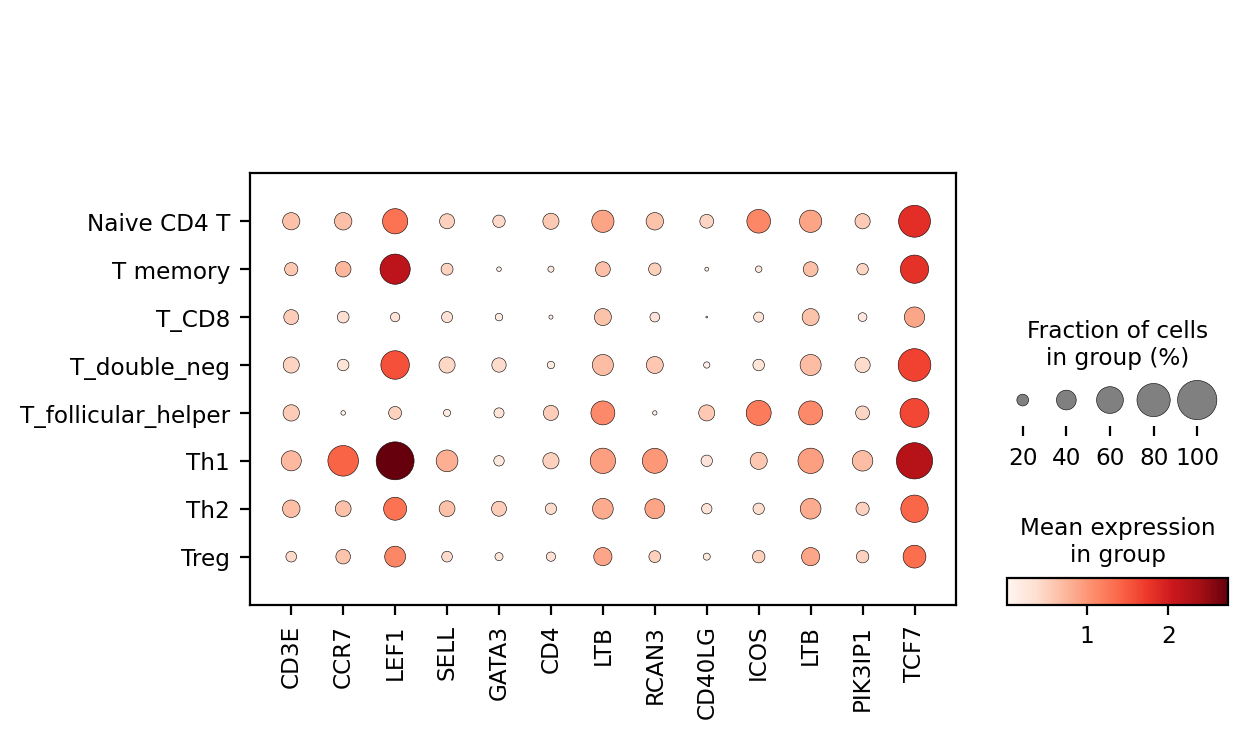

In [73]:
sc.pl.dotplot(
    adata[adata.obs['cell_type_major'] == 'T cells'], 
    var_names=['CD3E', 'CCR7', 'LEF1', 'SELL', 'GATA3','CD4', 'LTB', 'RCAN3','CD40LG', 'ICOS', 'LTB', 'PIK3IP1', 'TCF7'], 
    groupby='cell_type_2', 
)

In [8]:
%matplotlib inline

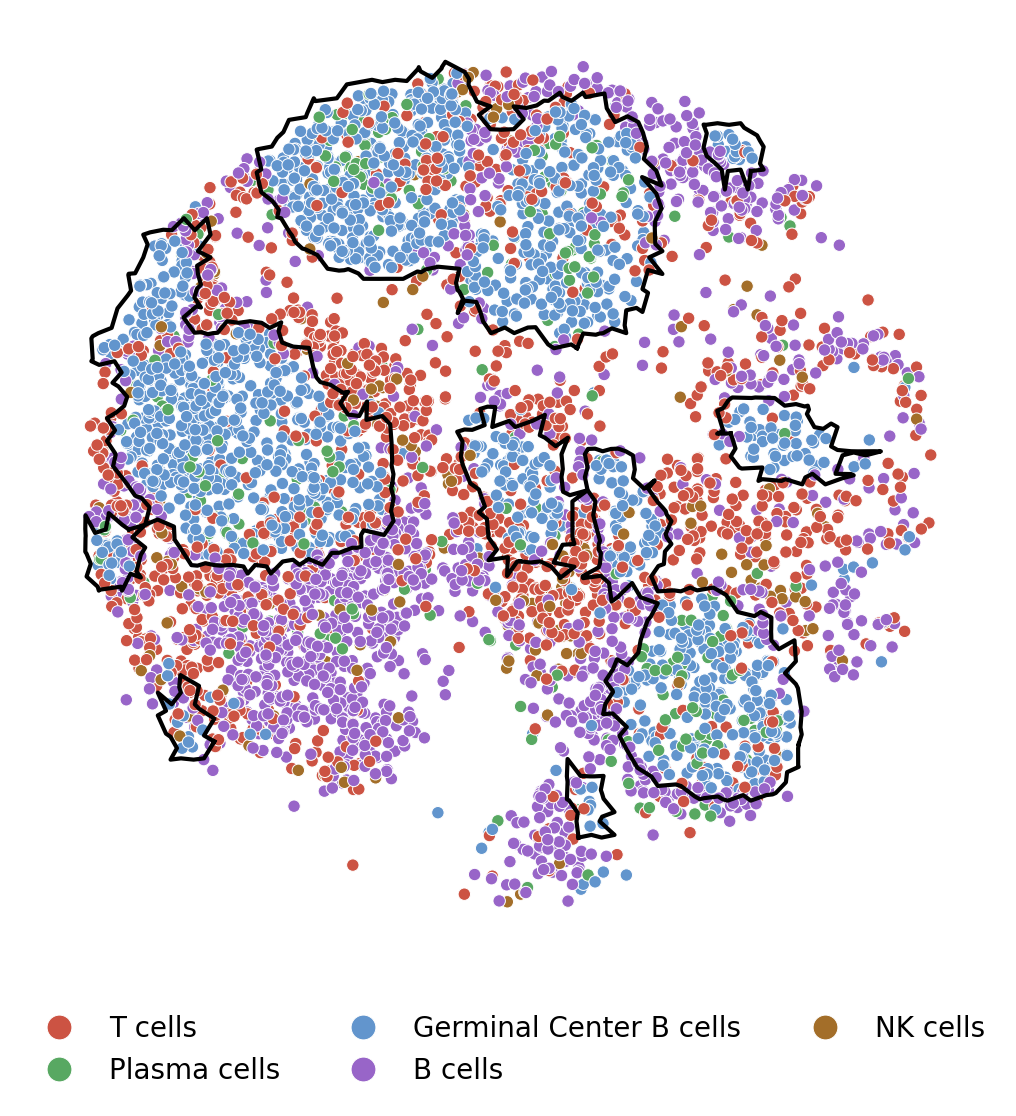

In [9]:
plt.rcParams['figure.figsize'] = (6, 6)

import alphashape

ct_points_wt = {}
for ct in adata.obs['cell_type_major'].unique():
    points = np.asarray(
        adata[adata.obs['cell_type_major'] == ct].obsm['spatial'])
    delta = 30
    points = np.vstack(
        (points +[-delta,delta], points +[-delta,-delta], 
        points +[delta,delta], points +[delta,-delta]))
    ct_points_wt[ct] = points

adatax = adata[~adata.obs.cell_type_major.isin([
    'Myeloid cells', 'Dendritic cells'])]
sns.scatterplot(data=adatax.obs, 
    x=adatax.obsm['spatial'][:,0], 
    y=adatax.obsm['spatial'][:,1],
    s=20,
    hue='cell_type_major',
    legend='brief', palette=color_dict)
plt.axis('off')

alpha_shape = alphashape.alphashape(ct_points_wt['Germinal Center B cells'], alpha=0.035)
for geom in alpha_shape.geoms:
    if geom.area > 10000:
        plt.plot(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color='black', alpha=1)
plt.legend(bbox_to_anchor=(0.5, -0.05), 
    loc='upper center', ncol=3, frameon=False, 
    markerscale=2, fontsize=10)
plt.savefig('./figures/tonsil_celltypes.svg', dpi=300, bbox_inches='tight', format='svg', transparent=True)
plt.show()

... storing 'cell_type_2' as categorical
... storing 'cell_type_major' as categorical


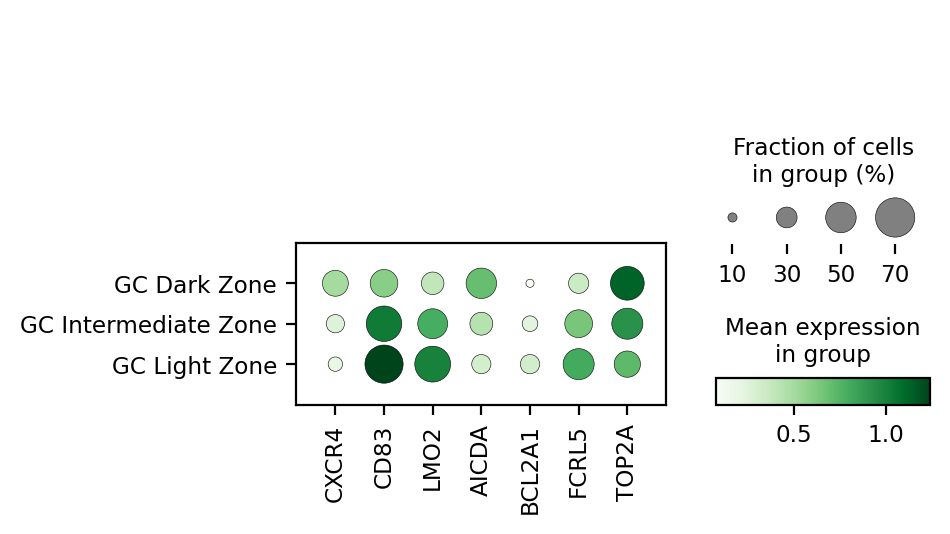

In [9]:
sc.pl.dotplot(adata[adata.obs.cell_type_2.str.contains('GC')], 
    var_names=['CXCR4', 'CD83', 'LMO2', 'AICDA', 'BCL2A1', 'FCRL5', 'TOP2A'], 
    groupby='cell_type_2', layer='normalized_count', cmap='Greens', show=False)

plt.savefig('./figures/dotplot_GC.svg', dpi=300, bbox_inches='tight', format='svg', transparent=True)

In [10]:
tonsil = VirtualTissue(
    adata = adata,
    annot = 'cell_type_2',
    betadatas_path = '/Volumes/SSD/lasso_runs/human_tonsil',
    ko_path = '/Volumes/SSD/genome_screens/human_tonsil',
    color_dict=color_dict
)

rename={
    'T_follicular_helper': 'T Follicular\nHelper',
    'T_CD8': 'T CD8+',
    'T_CD4': 'T CD4+',
    'B_germinal_center': 'B Germinal\nCenter',
    'B_naive': 'B\nNaive',
    'B_memory': 'B\nMemory',
}

In [22]:
from spaceoracle.models.parallel_estimators import create_spatial_features
from scipy.stats import pearsonr
from spaceoracle.plotting.cartography import xy_from_adata

RADIUS = 200

xy = xy_from_adata(adata)

spf = create_spatial_features(
    x=adata.obsm['spatial'][:, 0], 
    y=adata.obsm['spatial'][:, 1], 
    celltypes=adata.obs.cell_type_2, 
    obs_index=adata.obs_names,
    radius = RADIUS
)

In [12]:
cell_groups = {
    'GC B Cells': ['GC Light Zone', 'GC Dark Zone', 'GC Intermediate Zone'],
    'B cells': ['GC Light Zone', 'GC Dark Zone', 'GC Intermediate Zone', 'B_naive', 'B_memory'],
    'T cells': ['Naive CD4 T', 'T_follicular_helper', 'Th2', 'Th1', 'Treg'],
    'T cells': ['Naive CD4 T', 'T_follicular_helper', 'Th2', 'Th1', 'Treg'],
    'All T cells': ['Naive CD4 T', 'T_follicular_helper', 'Th2', 'Th1', 'Treg', 'T_CD8'],
    
}

In [13]:
def plot_gene_vs_proximity(perturb_target, gene, color_gene, cell_filter, 
                          proximity_threshold=150, gene_threshold=0.005, ax=None, mode='ko'):
    perturbed_df = pd.read_parquet(
        f'/Volumes/SSD/genome_screens/human_tonsil/{perturb_target}_4n_maxx.parquet')
    datadf = spf[
        [i+'_within' for i in cell_groups['GC B Cells']
            ]].sum(1).to_frame().join(adata.obs.cell_type_2).query(
             f'cell_type_2.isin(["{cell_filter}"])').join(xy).join(
        ((perturbed_df-adata.to_df(layer='imputed_count'))/adata.to_df(layer='imputed_count'))*100
    )
    datadf = datadf[datadf[0] < proximity_threshold]
    
    if ax is None:
        ax = plt.gca()
    
    try:
        corr = pearsonr(datadf[datadf[gene]>gene_threshold][0], datadf[datadf[gene]>gene_threshold][gene]).statistic
        ax.set_title(f"{perturb_target} {mode.upper()} in\n{cell_filter}\nCorrelation: {corr:.4f}")
    except:
        corr = 0
        ax.set_title(f"{perturb_target} {mode.upper()} in\n{cell_filter}")
        
    scatter = ax.scatter(
        datadf[0], 
        datadf[gene], 
        c=datadf[color_gene],
        cmap='rainbow',
    )
    plt.colorbar(scatter, label=f'{color_gene} % change', shrink=0.75, ax=ax)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylabel(f'{gene} % change')
    ax.set_xlabel(f'Number of GC B cells within {RADIUS}um')
    
    return ax, datadf

In [19]:
adata.obs.cell_type_2.unique()

array(['Th1', 'plasma', 'GC Light Zone', 'B_naive', 'B_memory',
       'GC Intermediate Zone', 'mDC', 'T_follicular_helper',
       'GC Dark Zone', 'NK', 'FDC', 'Naive CD4 T', 'T memory', 'T_CD8',
       'Treg', 'pDC', 'Th2', 'myeloid', 'T_double_neg'], dtype=object)

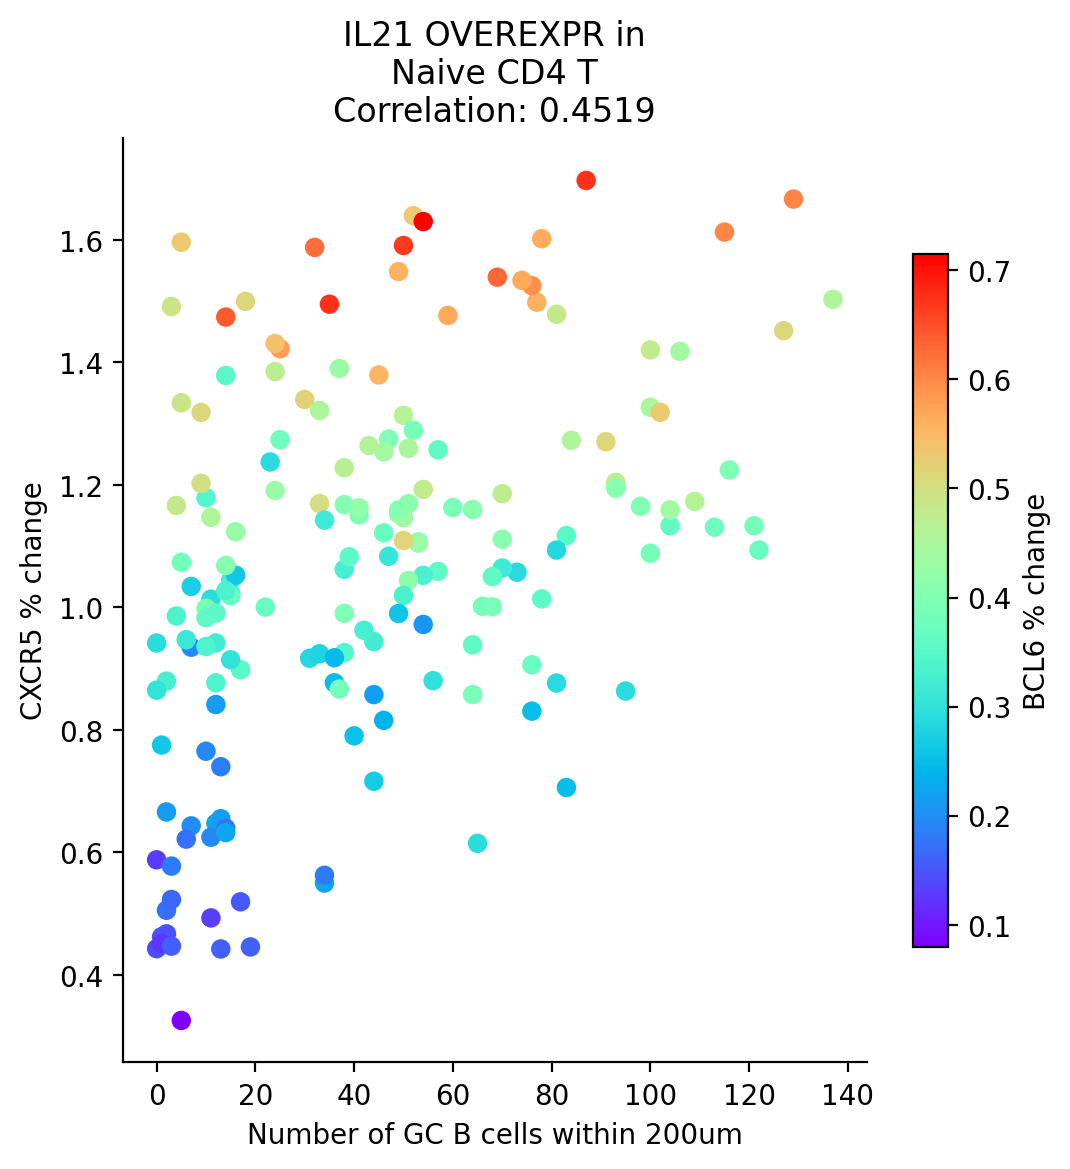

In [25]:
plot_gene_vs_proximity(
    perturb_target='IL21', 
    mode='OverExpr',
    gene='CXCR5', 
    color_gene='BCL6', 
    cell_filter='Naive CD4 T', 
)
plt.show()

In [95]:
tonsil.adata.obs.cell_type_2.value_counts()

cell_type_2
B_naive                 1088
GC Light Zone            735
GC Dark Zone             558
B_memory                 522
GC Intermediate Zone     467
T_follicular_helper      300
FDC                      288
plasma                   283
T memory                 264
T_CD8                    244
Treg                     198
Naive CD4 T              177
NK                       170
mDC                      137
myeloid                  102
Th1                       88
pDC                       64
Th2                       47
T_double_neg              46
Name: count, dtype: int64

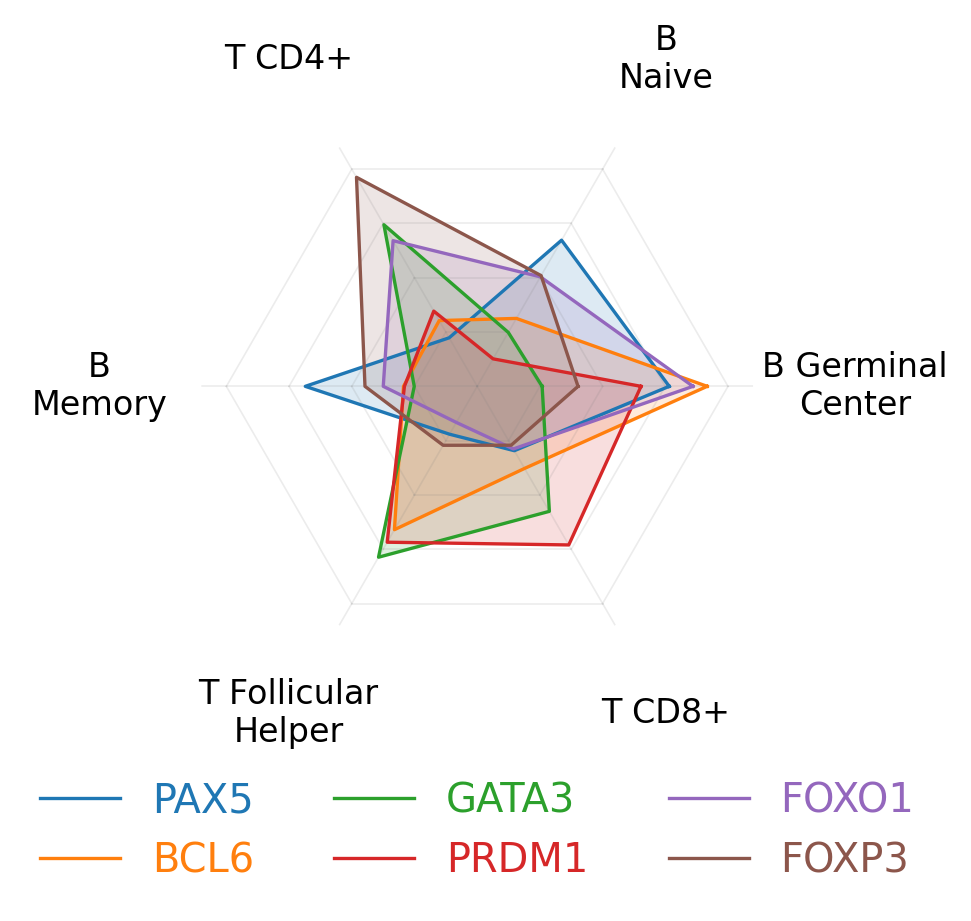

In [11]:
%matplotlib inline
tonsil.plot_radar(genes=[['PAX5', 'BCL6',  'GATA3', 'PRDM1', 'FOXO1', 'FOXP3']], 
    show_for=['B_germinal_center', 'B_naive', 'T_CD4', 
    'B_memory', 'T_follicular_helper', 'T_CD8'], 
    cache_path='../../notebooks/human_tonsil/', 
    figsize=(10, 4),
    dpi=120,
    rename=rename)

plt.savefig('./figures/spider_plot_tf.svg', dpi=300, bbox_inches='tight', format='svg', transparent=True)
plt.show()

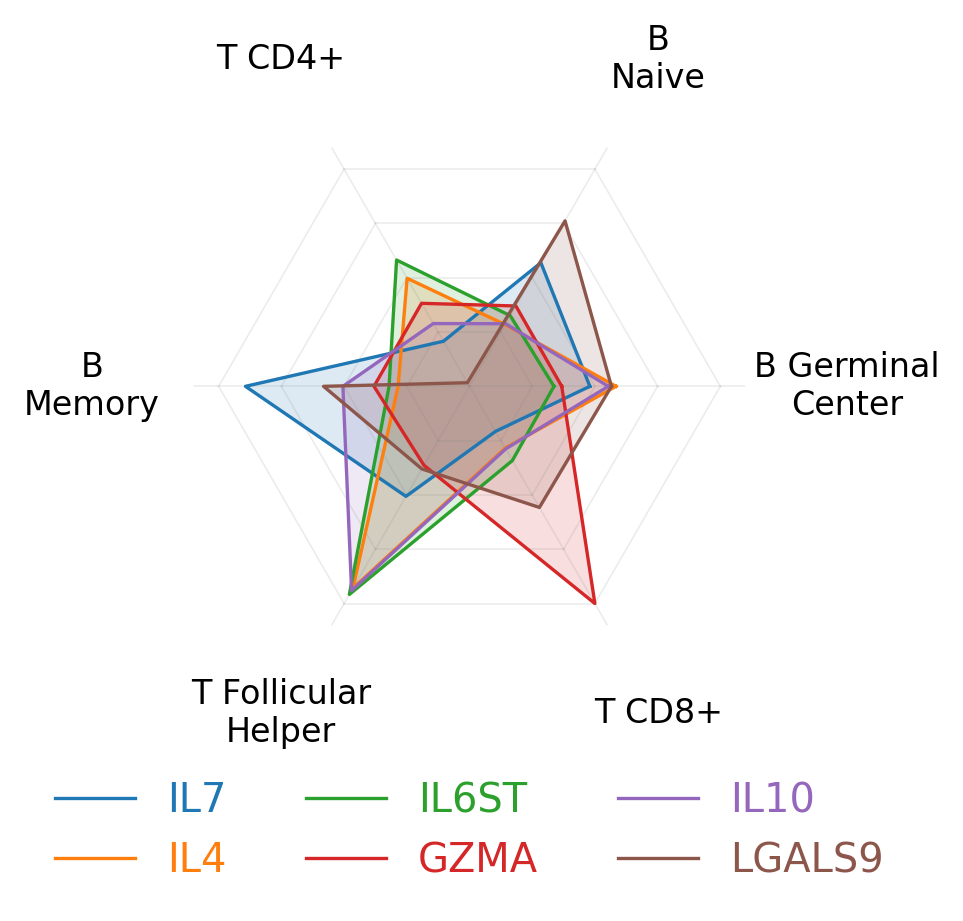

In [12]:
%matplotlib inline
tonsil.plot_radar(genes=[['IL7', 'IL4',  'IL6ST', 'GZMA', 'IL10', 'LGALS9']], 
    show_for=['B_germinal_center', 'B_naive', 'T_CD4', 
    'B_memory', 'T_follicular_helper', 'T_CD8'], 
    cache_path='../../notebooks/human_tonsil/', 
    figsize=(10, 4),
    dpi=120,
    rename=rename)

plt.savefig('./figures/spider_plot_ligands.svg', dpi=300, bbox_inches='tight', format='svg', transparent=True)
plt.show()

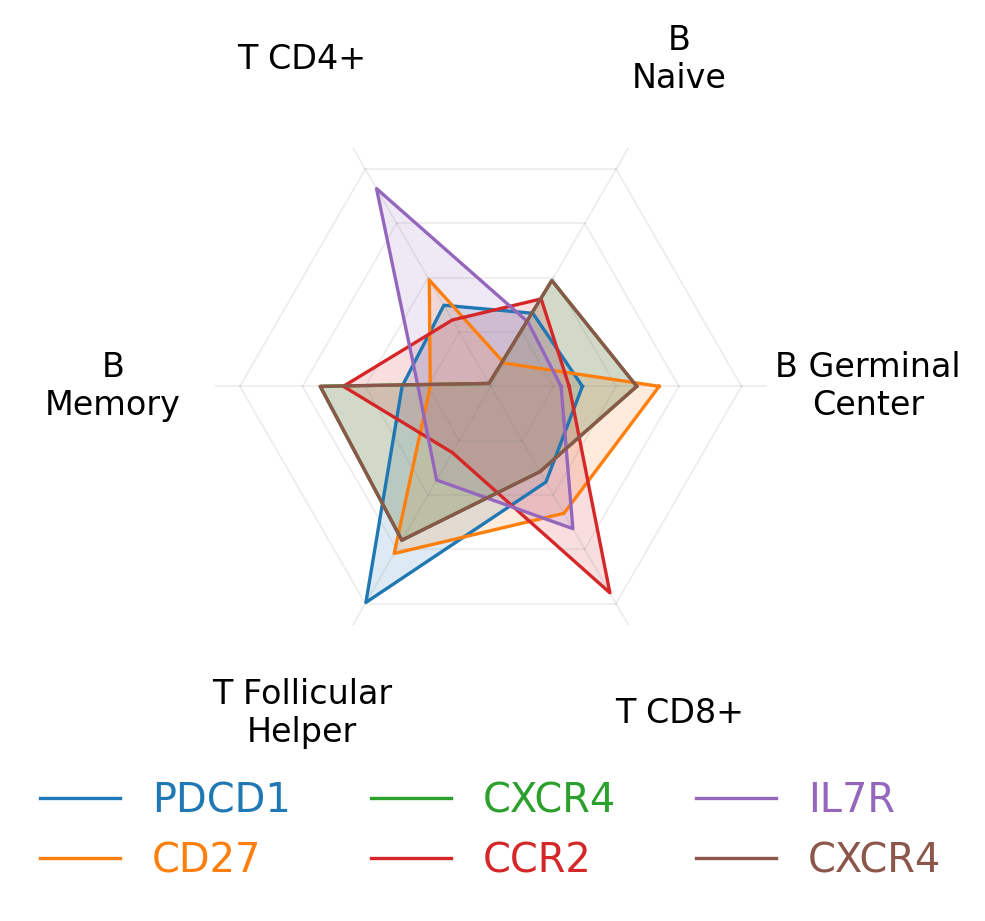

In [13]:
%matplotlib inline
tonsil.plot_radar(genes=[['PDCD1', 'CD27',  'CXCR4', 'CCR2', 'IL7R', 'CXCR4']], 
    show_for=['B_germinal_center', 'B_naive', 'T_CD4', 
    'B_memory', 'T_follicular_helper', 'T_CD8'], 
    cache_path='../../notebooks/human_tonsil/', 
    figsize=(10, 4),
    dpi=120,
    rename=rename)

plt.savefig('./figures/spider_plot_receptors.svg', dpi=300, bbox_inches='tight', format='svg', transparent=True)
plt.show()

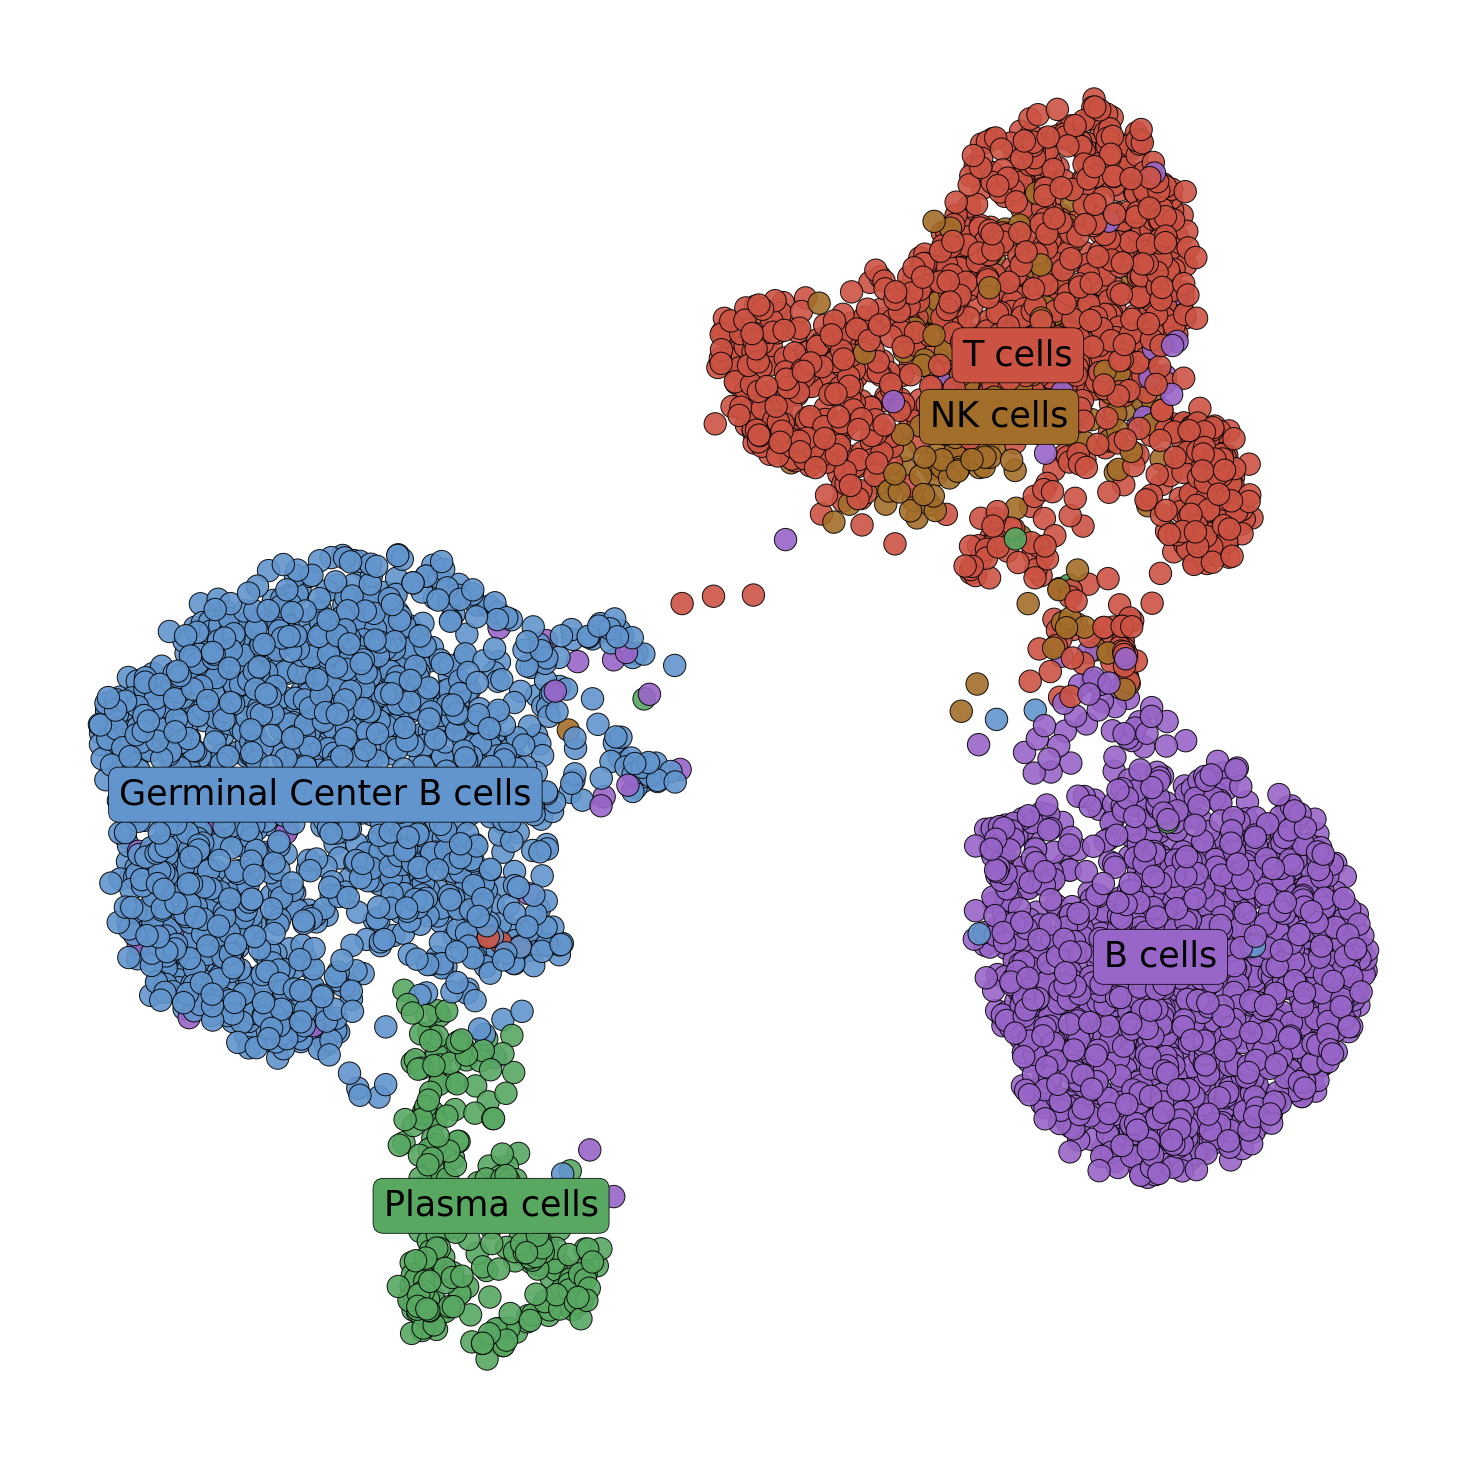

In [14]:
tonsil.init_cartography(adata[~adata.obs.cell_type_major.isin([
    'Myeloid cells', 'Dendritic cells'])])

tonsil.chart.plot_umap(
    hue='cell_type_major',
    color_dict=color_dict,
    scatter_size=20,
    linewidth=0.2,
    legend_fontsize=7,
)
plt.savefig('./figures/tonsil_umap.svg', dpi=300, format='svg', bbox_inches='tight', transparent=True)

In [15]:
atmp = adata[~adata.obs.index.isin(adata.obs.iloc[[2250, 2593, 3255, 5281]].index)]
# atmp = adata[pd.read_csv('GC_selection.csv', index_col=0).index]
# atmp = adata
tonsil.init_cartography(atmp, 
    restrict_to=[
        'Naive CD4 T',
        'T_follicular_helper', 
        'Th2', 
        'Th1', 
        'Treg',
        'T_CD8',
        
        # 'T memory',
         
        # 'GC Light Zone',
        # 'GC Dark Zone',
        # 'GC Intermediate Zone',
        # 'B_naive',
        # 'B_memory',
        # 'plasma'
        
    ]
)

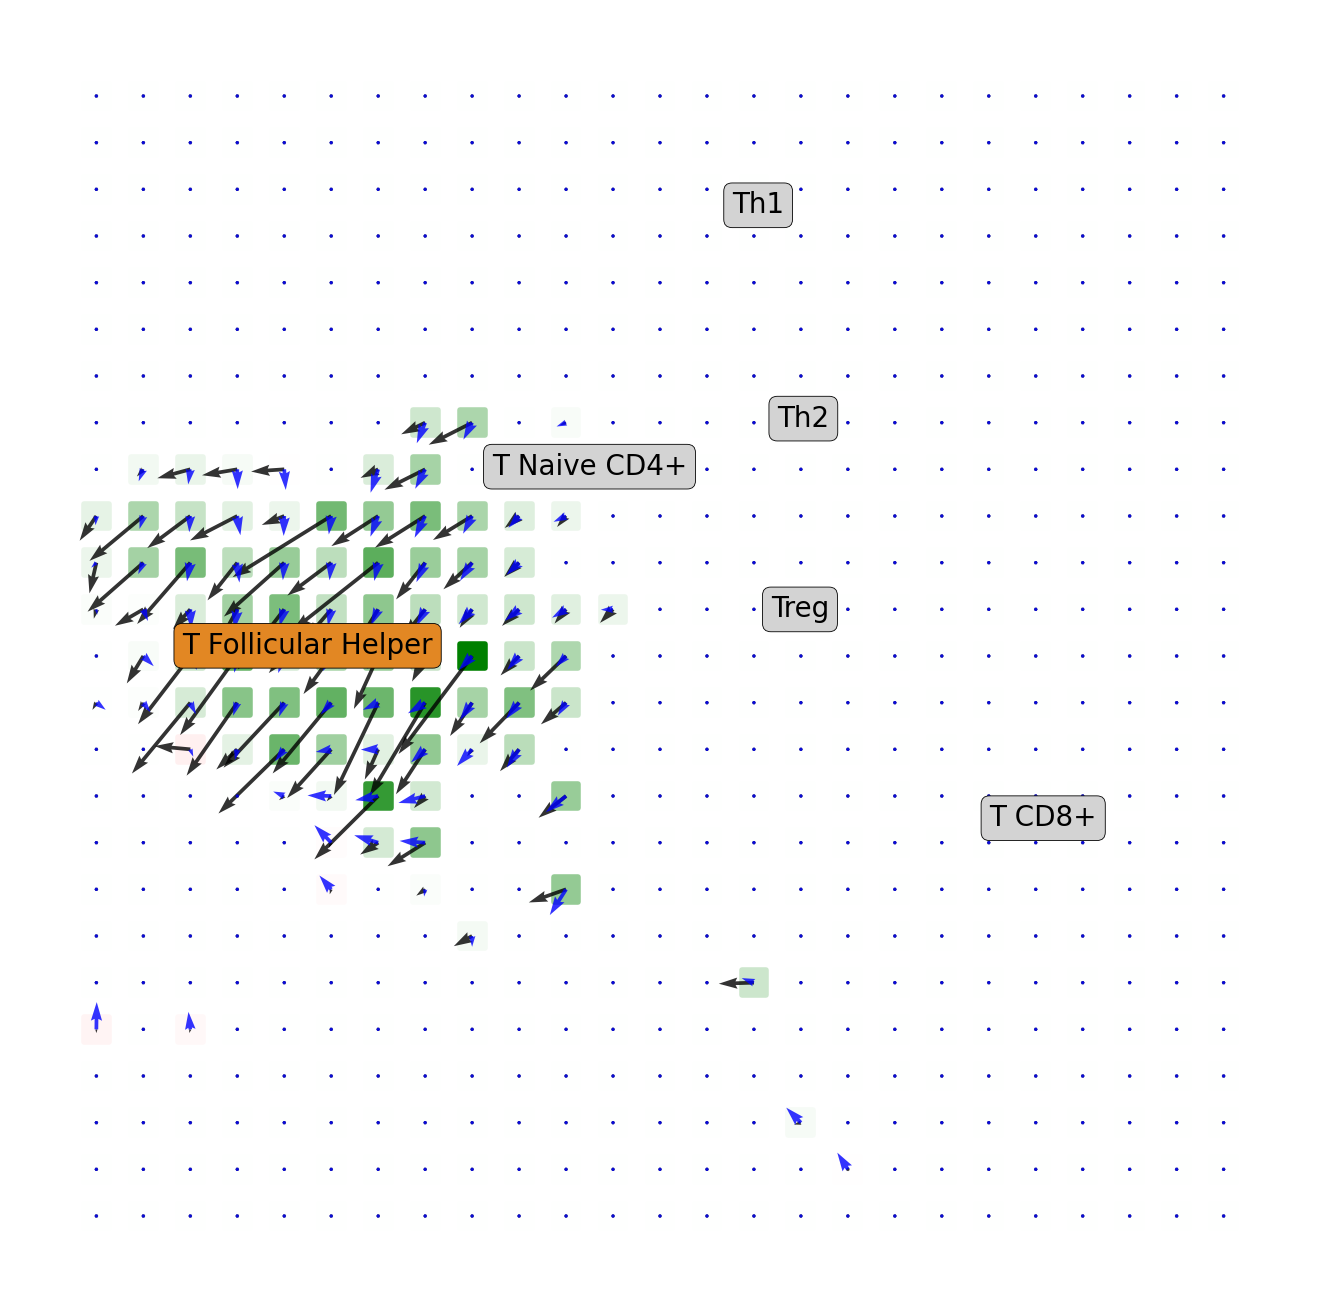

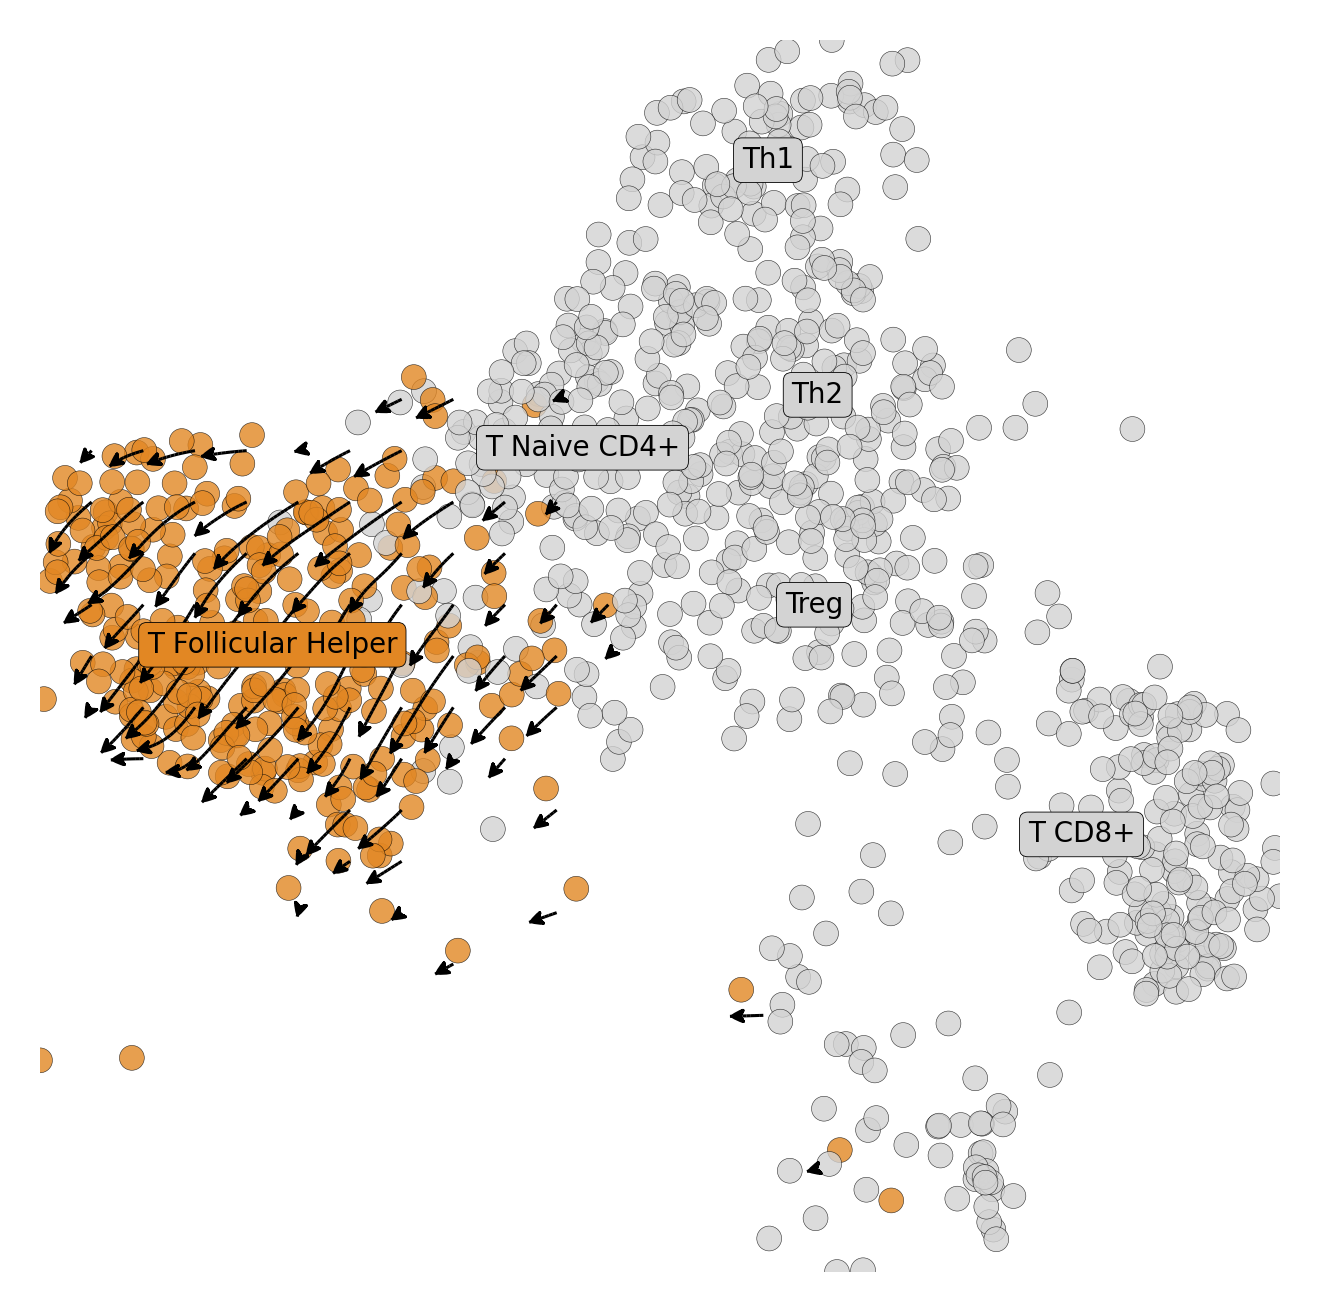

In [16]:
grid_points, vector_field = tonsil.plot_arrows_pseudotime(
    perturb_target='IL21', 
    perturbed_df=pd.read_parquet(
        '/Volumes/SSD/genome_screens/tonsil_special/IL21_OVX_T_follicular_helper.parquet'),
    # mode='max',
    mode='0',
    hue='cell_type_2',
    curve=True,
    vector_scale=0.02, 
    grid_scale=1,
    n_neighbors=160,
    scale=3, 
    grains=25,
    figsize=(4, 4),
    dpi=200,
    scatter_size=20,
    legend_fontsize=5,
    rename={
        'T_follicular_helper': 'T Follicular Helper',
        'T_CD8': 'T CD8+',
        'Naive CD4 T': 'T Naive CD4+',
    },
    iroot='Naive CD4 T',
    limit_clusters=True,
    highlight_clusters=[
        # 'Naive CD4 T',
        'T_follicular_helper', 
        # 'Th2', 
        # 'Th1', 
        # 'Treg',
        # 'T_CD8',
        # 'GC Light Zone',
        # 'GC Dark Zone',
        # 'GC Intermediate Zone',
        # 'B_memory',
        # 'B_naive',
        # 'plasma'
    ]
)

plt.savefig(
    './figures/IL21_OVX_Tfh_pseudotime.svg', 
    dpi=300, 
    bbox_inches='tight', 
    format='svg', 
    transparent=True
)

plt.show()


grid_points, vector_field = tonsil.plot_arrows(
    perturb_target='IL21', 
    perturbed_df=pd.read_parquet(
        '/Volumes/SSD/genome_screens/tonsil_special/IL21_OVX_T_follicular_helper.parquet'),
    # mode='max',
    mode='0',
    hue='cell_type_2',
    curve=True,
    vector_scale=0.02, 
    grid_scale=1,
    n_neighbors=160,
    scale=3, 
    grains=25,
    figsize=(4, 4),
    dpi=200,
    scatter_size=20,
    legend_fontsize=5,
    rename={
        'T_follicular_helper': 'T Follicular Helper',
        'T_CD8': 'T CD8+',
        'Naive CD4 T': 'T Naive CD4+',
    },
    limit_clusters=True,
    highlight_clusters=[
        # 'Naive CD4 T',
        'T_follicular_helper', 
        # 'Th2', 
        # 'Th1', 
        # 'Treg',
        # 'T_CD8',
        # 'GC Light Zone',
        # 'GC Dark Zone',
        # 'GC Intermediate Zone',
        # 'B_memory',
        # 'B_naive',
        # 'plasma'
    ]
)

plt.savefig(
    './figures/IL21_OVX_Tfh.svg', 
    dpi=300, 
    bbox_inches='tight', 
    format='svg', 
    transparent=True
)

plt.show()

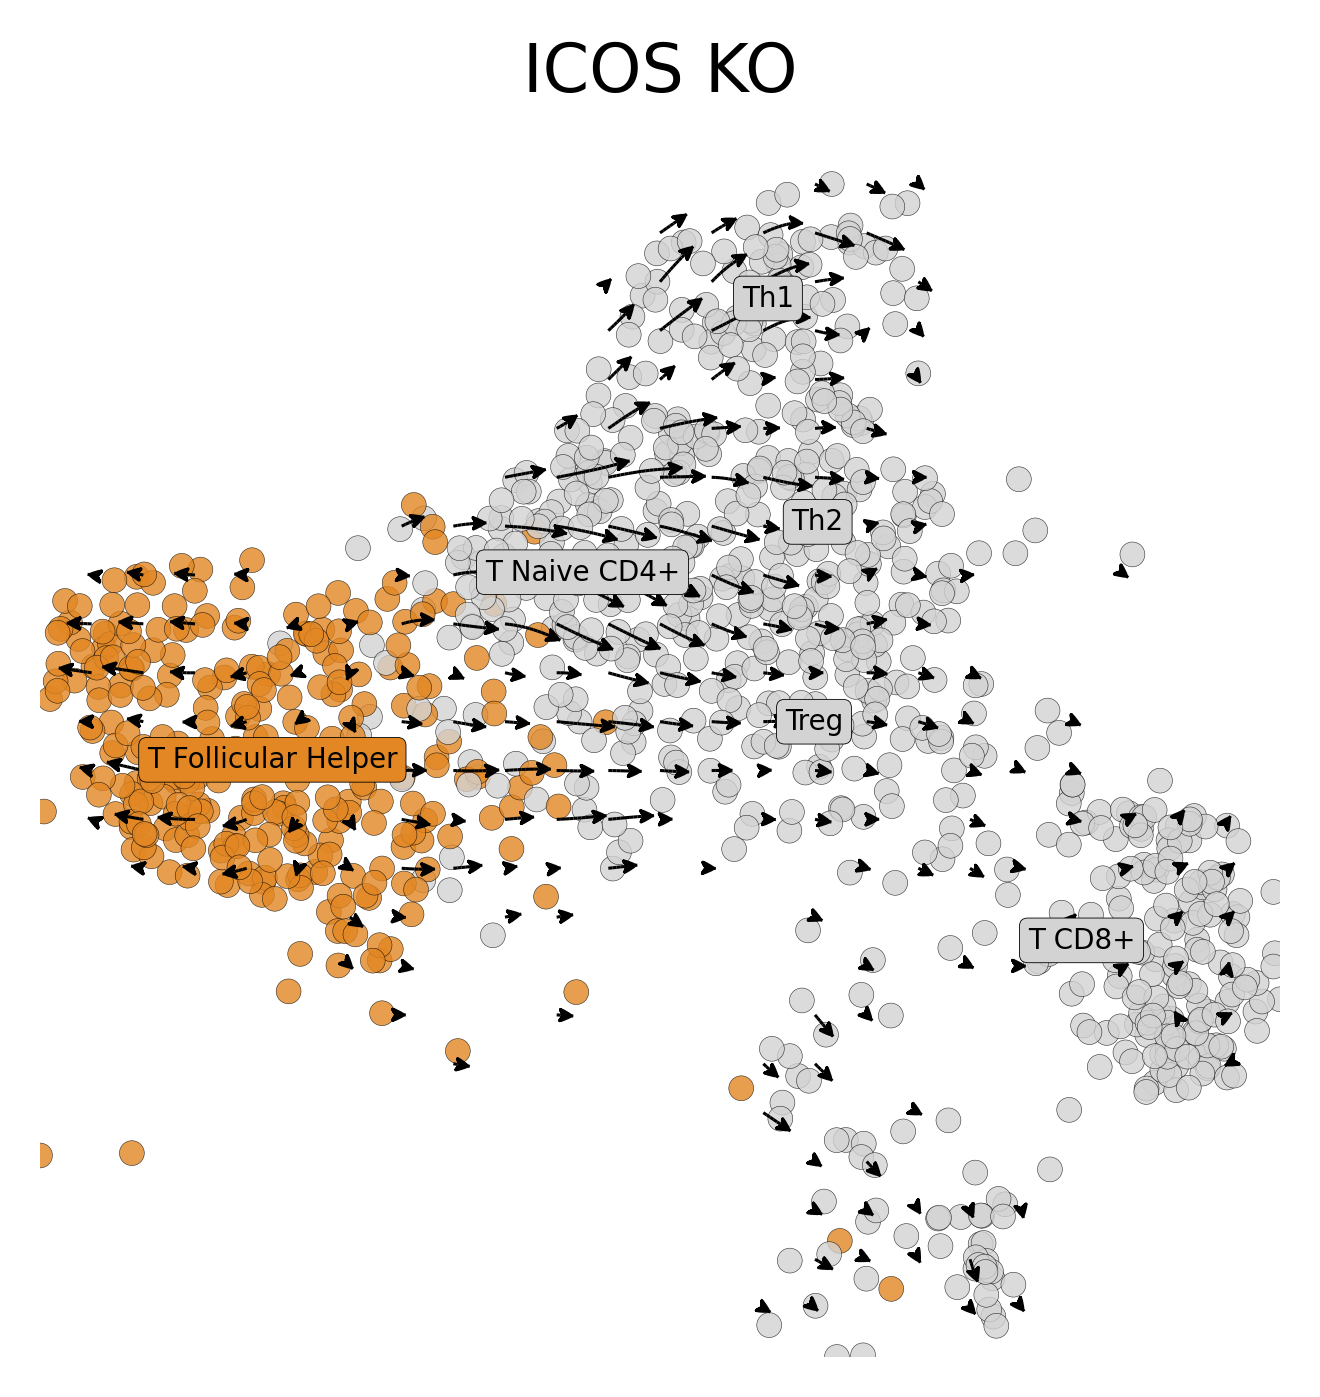

In [42]:

perturbed_df = pd.read_parquet(
    '/Volumes/SSD/genome_screens/human_tonsil/ICOS_4n_0x.parquet')

grid_points, vector_field = tonsil.plot_arrows(
    perturb_target='', 
    perturbed_df=perturbed_df,
    mode='0',
    hue='cell_type_2',
    curve=True,
    vector_scale=0.4, 
    grid_scale=1,
    n_neighbors=200,
    scale=2, 
    grains=25,
    figsize=(4, 4),
    dpi=200,
    scatter_size=20,
    legend_fontsize=5,
    rename={
        'T_follicular_helper': 'T Follicular Helper',
        'T_CD8': 'T CD8+',
        'Naive CD4 T': 'T Naive CD4+',
    },
    limit_clusters=False,
    highlight_clusters=[
        'T_follicular_helper', 
    ]
)

plt.title('ICOS KO')

plt.savefig(
    './figures/ICOS_KO.svg', 
    dpi=300, 
    bbox_inches='tight', 
    format='svg', 
    transparent=True
)

plt.show()

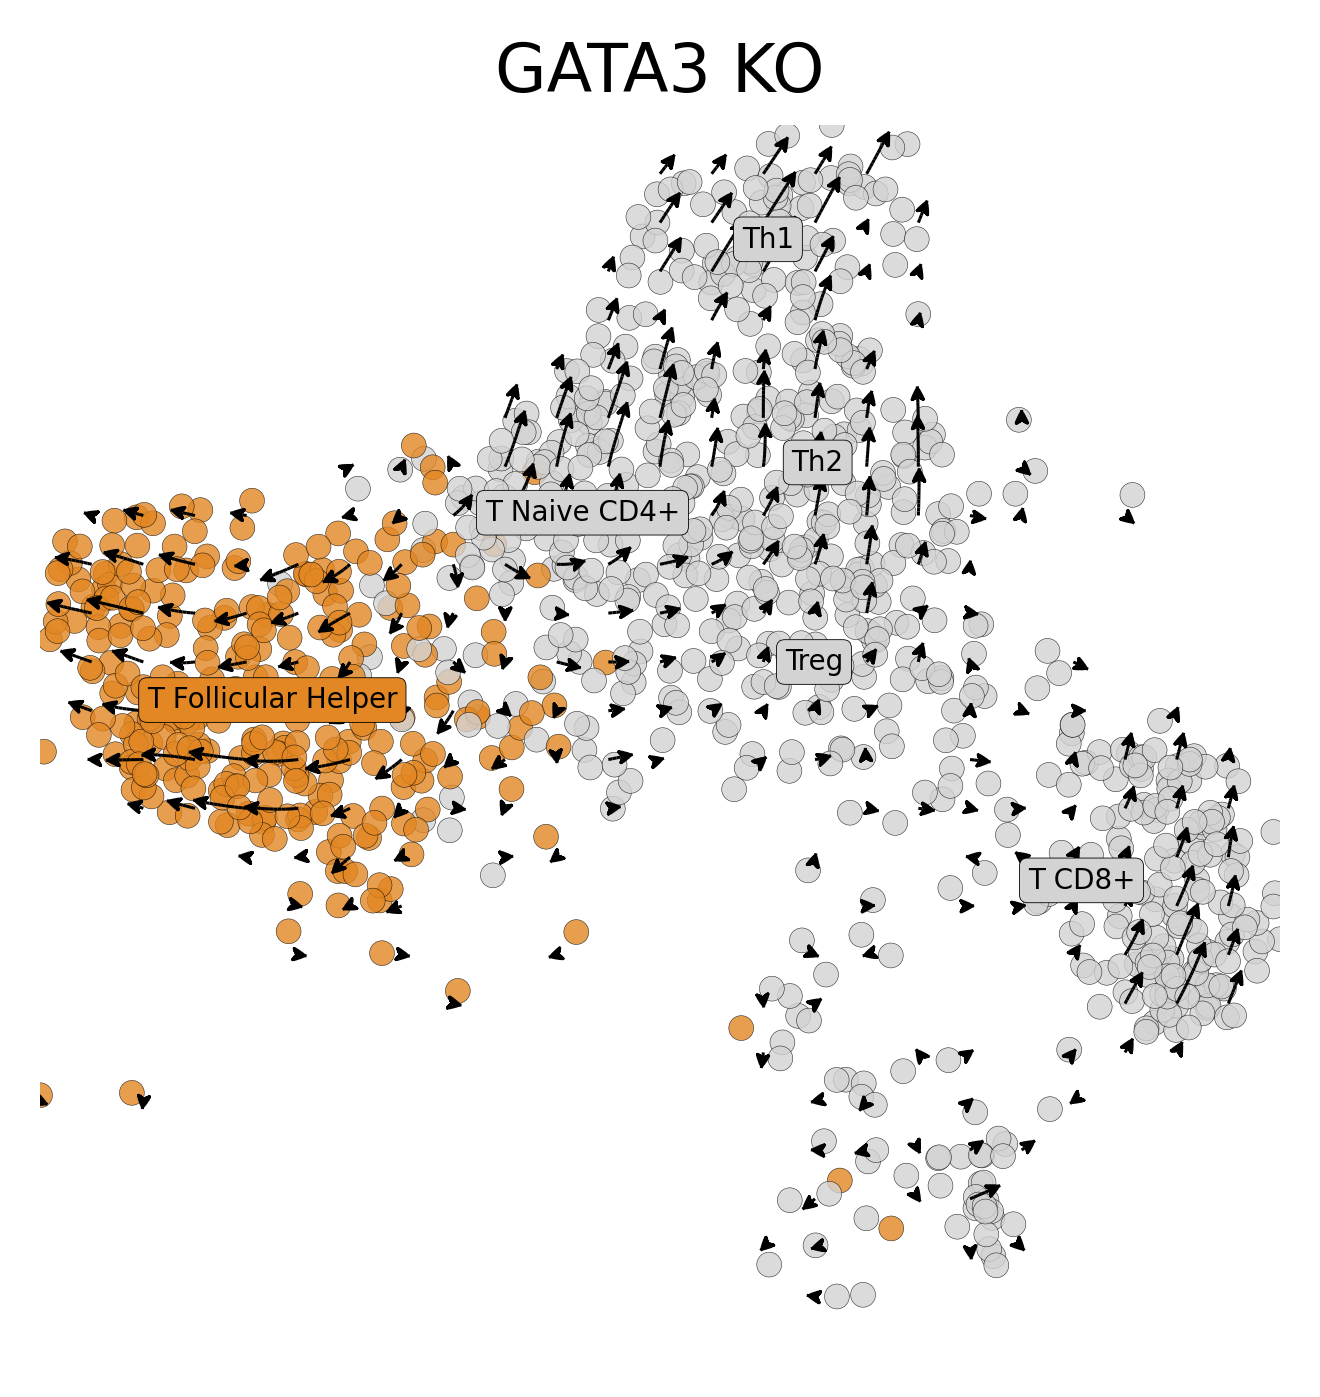

In [40]:
perturbed_df = pd.read_parquet(
    '/Volumes/SSD/genome_screens/human_tonsil/GATA3_4n_0x.parquet')


grid_points, vector_field = tonsil.plot_arrows(
    perturb_target='', 
    perturbed_df=perturbed_df,
    mode='0',
    hue='cell_type_2',
    curve=True,
    vector_scale=0.4, 
    grid_scale=1,
    n_neighbors=200,
    scale=2, 
    grains=25,
    figsize=(4, 4),
    dpi=200,
    scatter_size=20,
    legend_fontsize=5,
    rename={
        'T_follicular_helper': 'T Follicular Helper',
        'T_CD8': 'T CD8+',
        'Naive CD4 T': 'T Naive CD4+',
    },
    limit_clusters=False,
    highlight_clusters=[
        'T_follicular_helper', 

    ]
)

plt.title('GATA3 KO')

plt.savefig(
    './figures/GATA3_KO.svg', 
    dpi=300, 
    bbox_inches='tight', 
    format='svg', 
    transparent=True
)

plt.show()

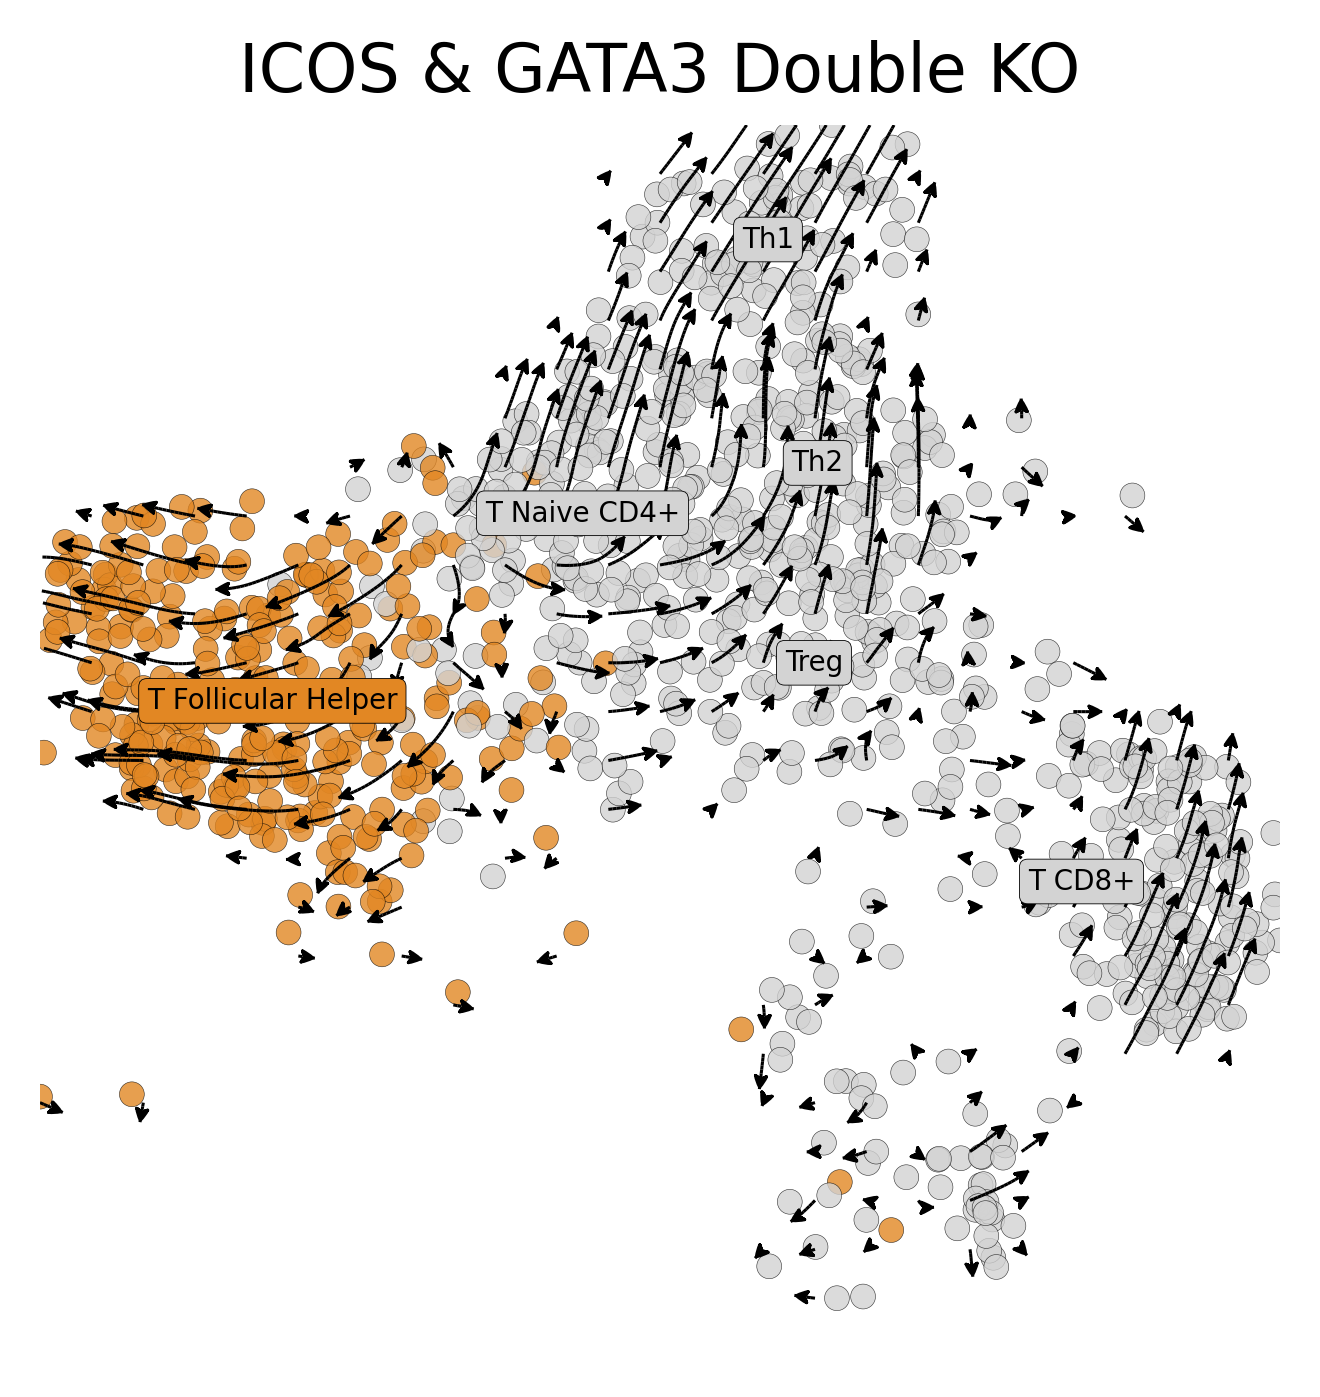

In [39]:
perturbed_df = pd.read_parquet(
    '/Volumes/SSD/genome_screens/tonsil_special/ICOS_4n_0x_GATA3_4n_0x.parquet')

grid_points, vector_field = tonsil.plot_arrows(
    perturb_target='', 
    perturbed_df=perturbed_df,
    mode='0',
    hue='cell_type_2',
    curve=True,
    vector_scale=0.4, 
    grid_scale=1,
    n_neighbors=200,
    scale=5, 
    grains=25,
    figsize=(4, 4),
    dpi=200,
    scatter_size=20,
    legend_fontsize=5,
    rename={
        'T_follicular_helper': 'T Follicular Helper',
        'T_CD8': 'T CD8+',
        'Naive CD4 T': 'T Naive CD4+',
    },
    limit_clusters=False,
    highlight_clusters=[
        'T_follicular_helper', 

    ]
)

plt.title('ICOS & GATA3 Double KO')

plt.savefig(
    './figures/ICOS_GATA3_KO.svg', 
    dpi=300, 
    bbox_inches='tight', 
    format='svg', 
    transparent=True
)

plt.show()

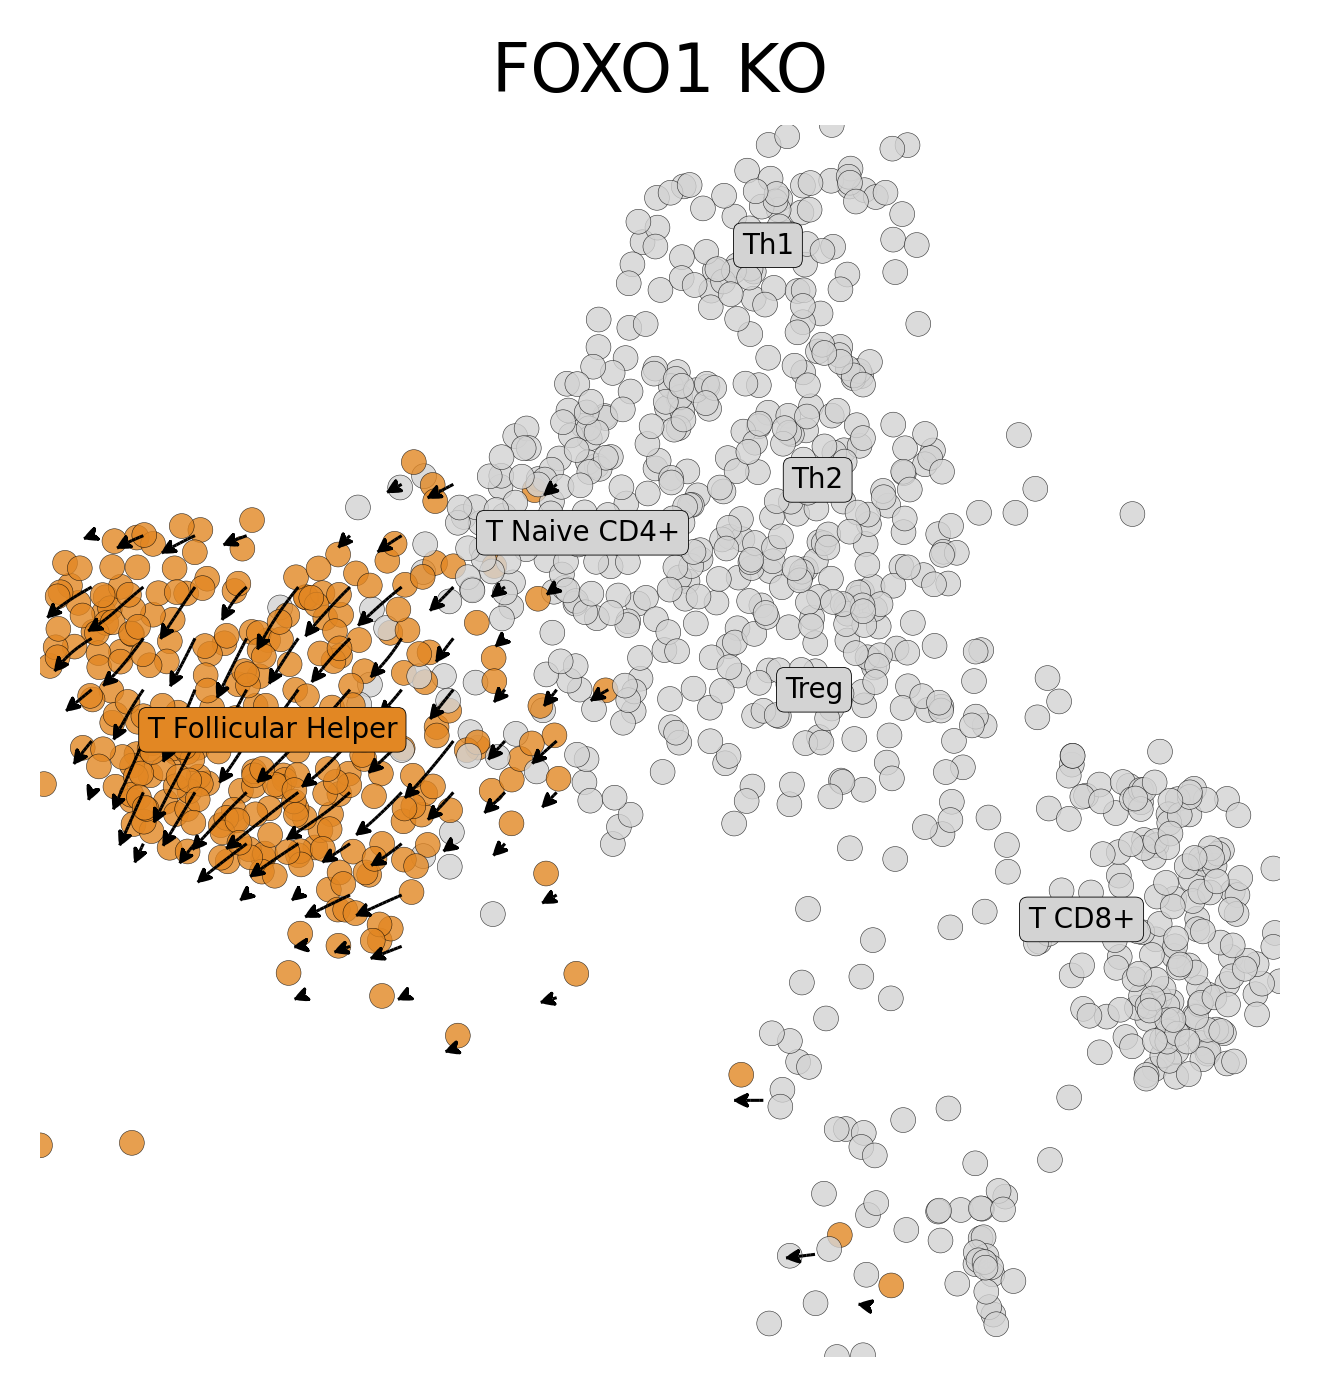

In [54]:

perturbed_df = pd.read_parquet(
    '/Volumes/SSD/genome_screens/human_tonsil/FOXO1_4n_0x.parquet')

grid_points, vector_field = tonsil.plot_arrows(
    perturb_target='', 
    perturbed_df=perturbed_df,
    mode='0',
    hue='cell_type_2',
    curve=True,
    vector_scale=0.4, 
    grid_scale=1,
    n_neighbors=200,
    scale=2.2, 
    grains=25,
    figsize=(4, 4),
    dpi=200,
    scatter_size=20,
    legend_fontsize=5,
    rename={
        'T_follicular_helper': 'T Follicular Helper',
        'T_CD8': 'T CD8+',
        'Naive CD4 T': 'T Naive CD4+',
    },
    limit_clusters=True,
    highlight_clusters=[
        'T_follicular_helper', 
    ]
)

plt.title('FOXO1 KO')

plt.savefig(
    './figures/FOXO1_KO.svg', 
    dpi=300, 
    bbox_inches='tight', 
    format='svg', 
    transparent=True
)

plt.show()

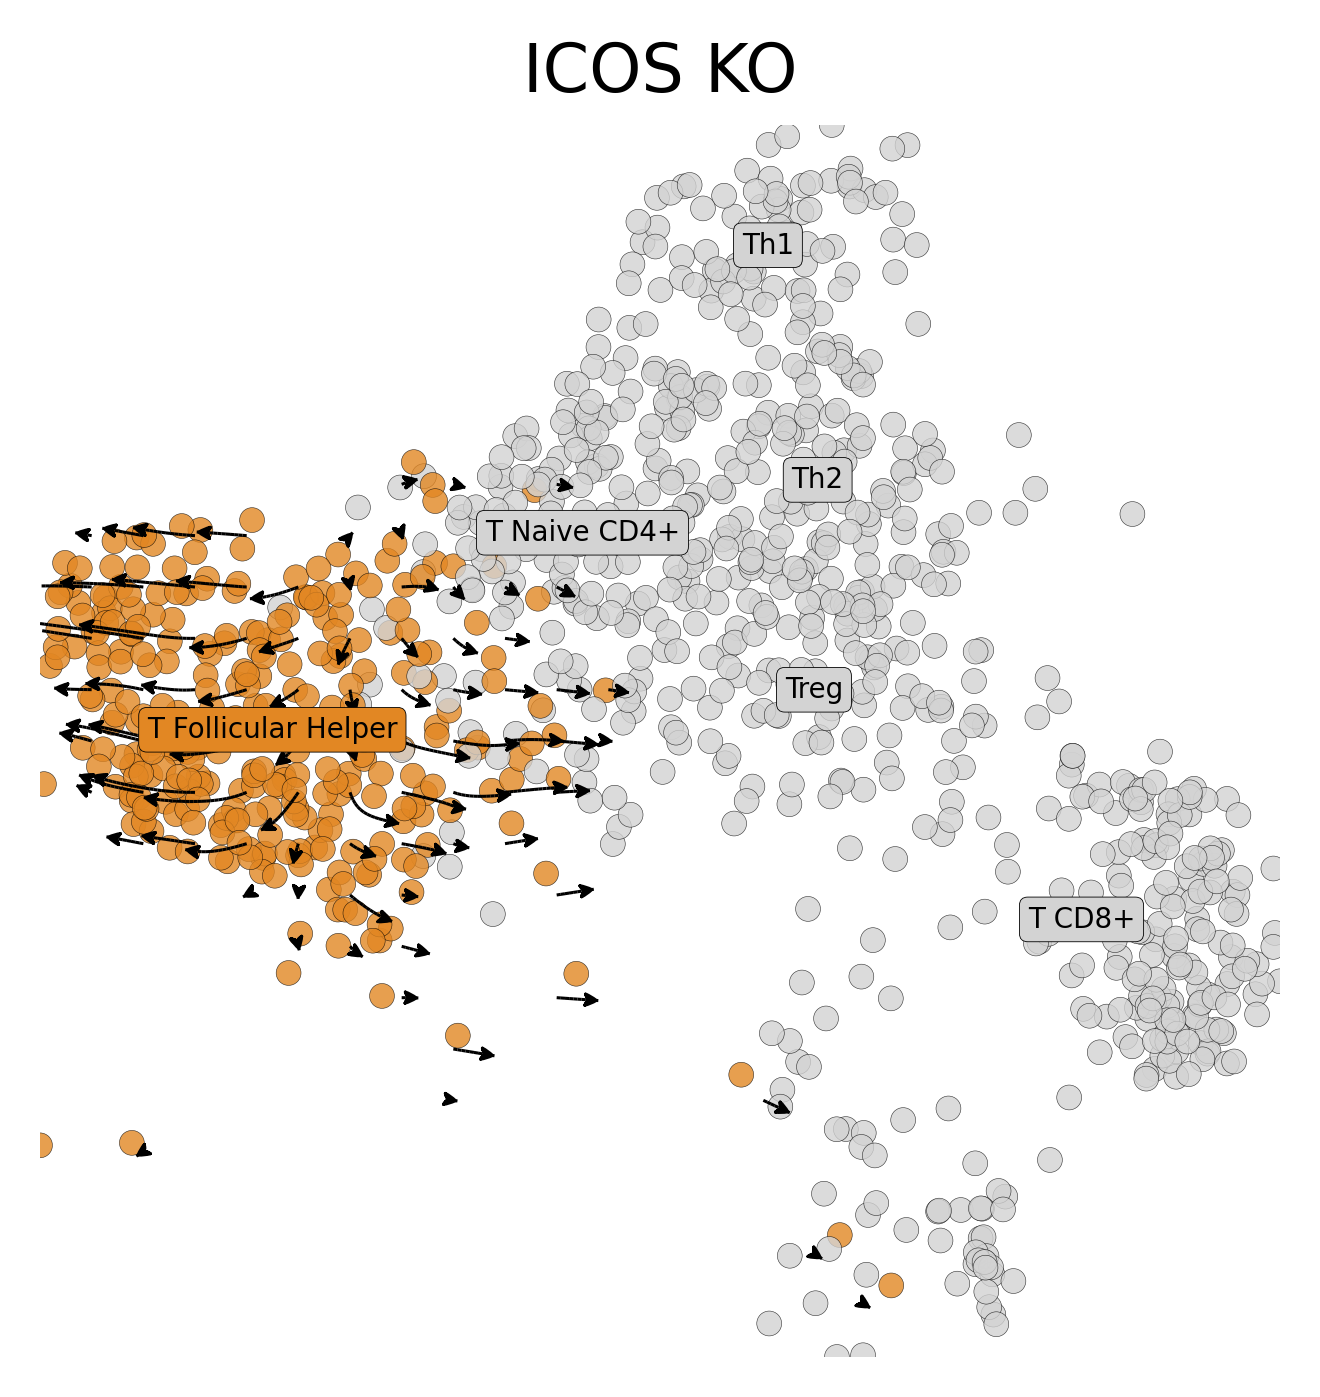

In [58]:

perturbed_df = pd.read_parquet(
    '/Volumes/SSD/genome_screens/human_tonsil/ICOS_4n_0x.parquet')

grid_points, vector_field = tonsil.plot_arrows(
    perturb_target='', 
    perturbed_df=perturbed_df,
    mode='0',
    hue='cell_type_2',
    curve=True,
    vector_scale=0.4, 
    grid_scale=1,
    n_neighbors=200,
    scale=3, 
    grains=25,
    figsize=(4, 4),
    dpi=200,
    scatter_size=20,
    legend_fontsize=5,
    rename={
        'T_follicular_helper': 'T Follicular Helper',
        'T_CD8': 'T CD8+',
        'Naive CD4 T': 'T Naive CD4+',
    },
    limit_clusters=True,
    highlight_clusters=[
        'T_follicular_helper', 
    ]
)

plt.title('ICOS KO')

plt.savefig(
    './figures/ICOS_KO.svg', 
    dpi=300, 
    bbox_inches='tight', 
    format='svg', 
    transparent=True
)

plt.show()

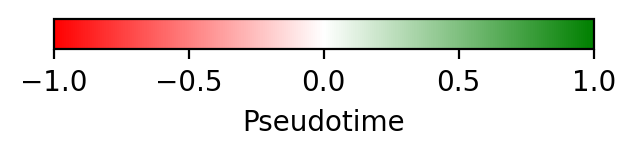

In [23]:
fig = plt.figure(figsize=(3, 1), dpi=100)
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = LinearSegmentedColormap.from_list('custom', ['red', 'white', 'green'])
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Pseudotime')
plt.savefig('./figures/pseudotime_colorbar.svg', dpi=300, bbox_inches='tight', format='svg', transparent=True)
plt.show()

In [24]:
atmp = adata[~adata.obs.index.isin(adata.obs.iloc[[2250, 2593, 3255, 5281]].index)]

In [25]:
atmp = atmp[atmp.obs.cell_type_2.isin([
        'Naive CD4 T',
        'T_follicular_helper', 
        'Th2', 
        'Th1', 
        'Treg',
        # 'T_CD8',
    ])]

In [46]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')
adata.obsm['X_umap'] = pd.read_csv('../../notebooks/human_tonsil/umap.csv', index_col=0).values
adata.obs = adata.obs.join(pd.read_csv('../../notebooks/human_tonsil/tonsil_cell_types.csv', index_col=0))
sc.pp.pca(adata)
sc.pp.neighbors(adata)
adata.layers['imputed_count'] = np.load('../../notebooks/human_tonsil/imputed_counts.npy')

In [55]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['cell_type_2'] == 'T_follicular_helper')[0]
sc.tl.diffmap(adata)
sc.tl.dpt(adata, n_dcs=10, n_branchings=0)

... storing 'cell_type_2' as categorical


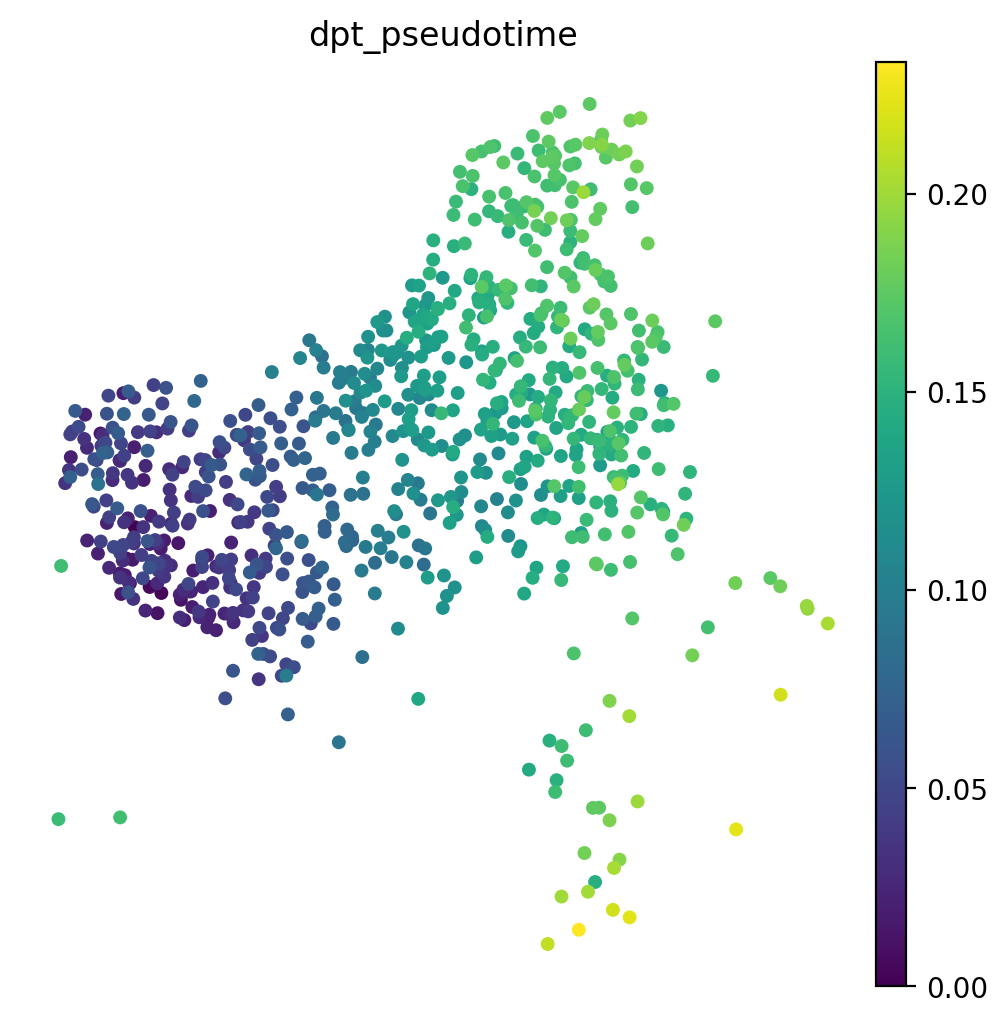

In [56]:
sc.pl.umap(adata[atmp.obs_names], color=['dpt_pseudotime'], size=100, frameon=False)

In [321]:
from celloracle.applications.differentiation_flow import get_gradient, normalize_gradient
import random
from spaceoracle.virtual_tissue import VirtualTissue

from sklearn.neighbors import KNeighborsRegressor

def _knn_regression(x, y, x_new, y_new, value, n_knn=30):

    data = np.stack([x, y], axis=1)

    model = KNeighborsRegressor(n_neighbors=n_knn)
    model.fit(data, value)

    data_new = np.stack([x_new, y_new], axis=1)

    return model.predict(data_new)

In [349]:
embedding = adata.obsm['X_umap']
x, y = embedding[:, 0], embedding[:, 1]
x_new, y_new = grid_points[:, 0], grid_points[:, 1]

value = adata.obs.dpt_pseudotime.values
# value = tonsil.load_betadata(gene='IL21')['beta_FOXP3'].values

pseudotime_on_grid = _knn_regression(x, y, x_new, y_new, value, n_knn=30)
gradient = get_gradient(value_on_grid=pseudotime_on_grid)
gradient = normalize_gradient(gradient, method="sqrt")
l2_norm = np.linalg.norm(gradient, ord=2, axis=1)
scale_factor = 1 / l2_norm.mean()
ref_flow = gradient * 2

zero_mask = (vector_field[:,0] == 0) & (vector_field[:,1] == 0)
ref_flow[zero_mask] = 0

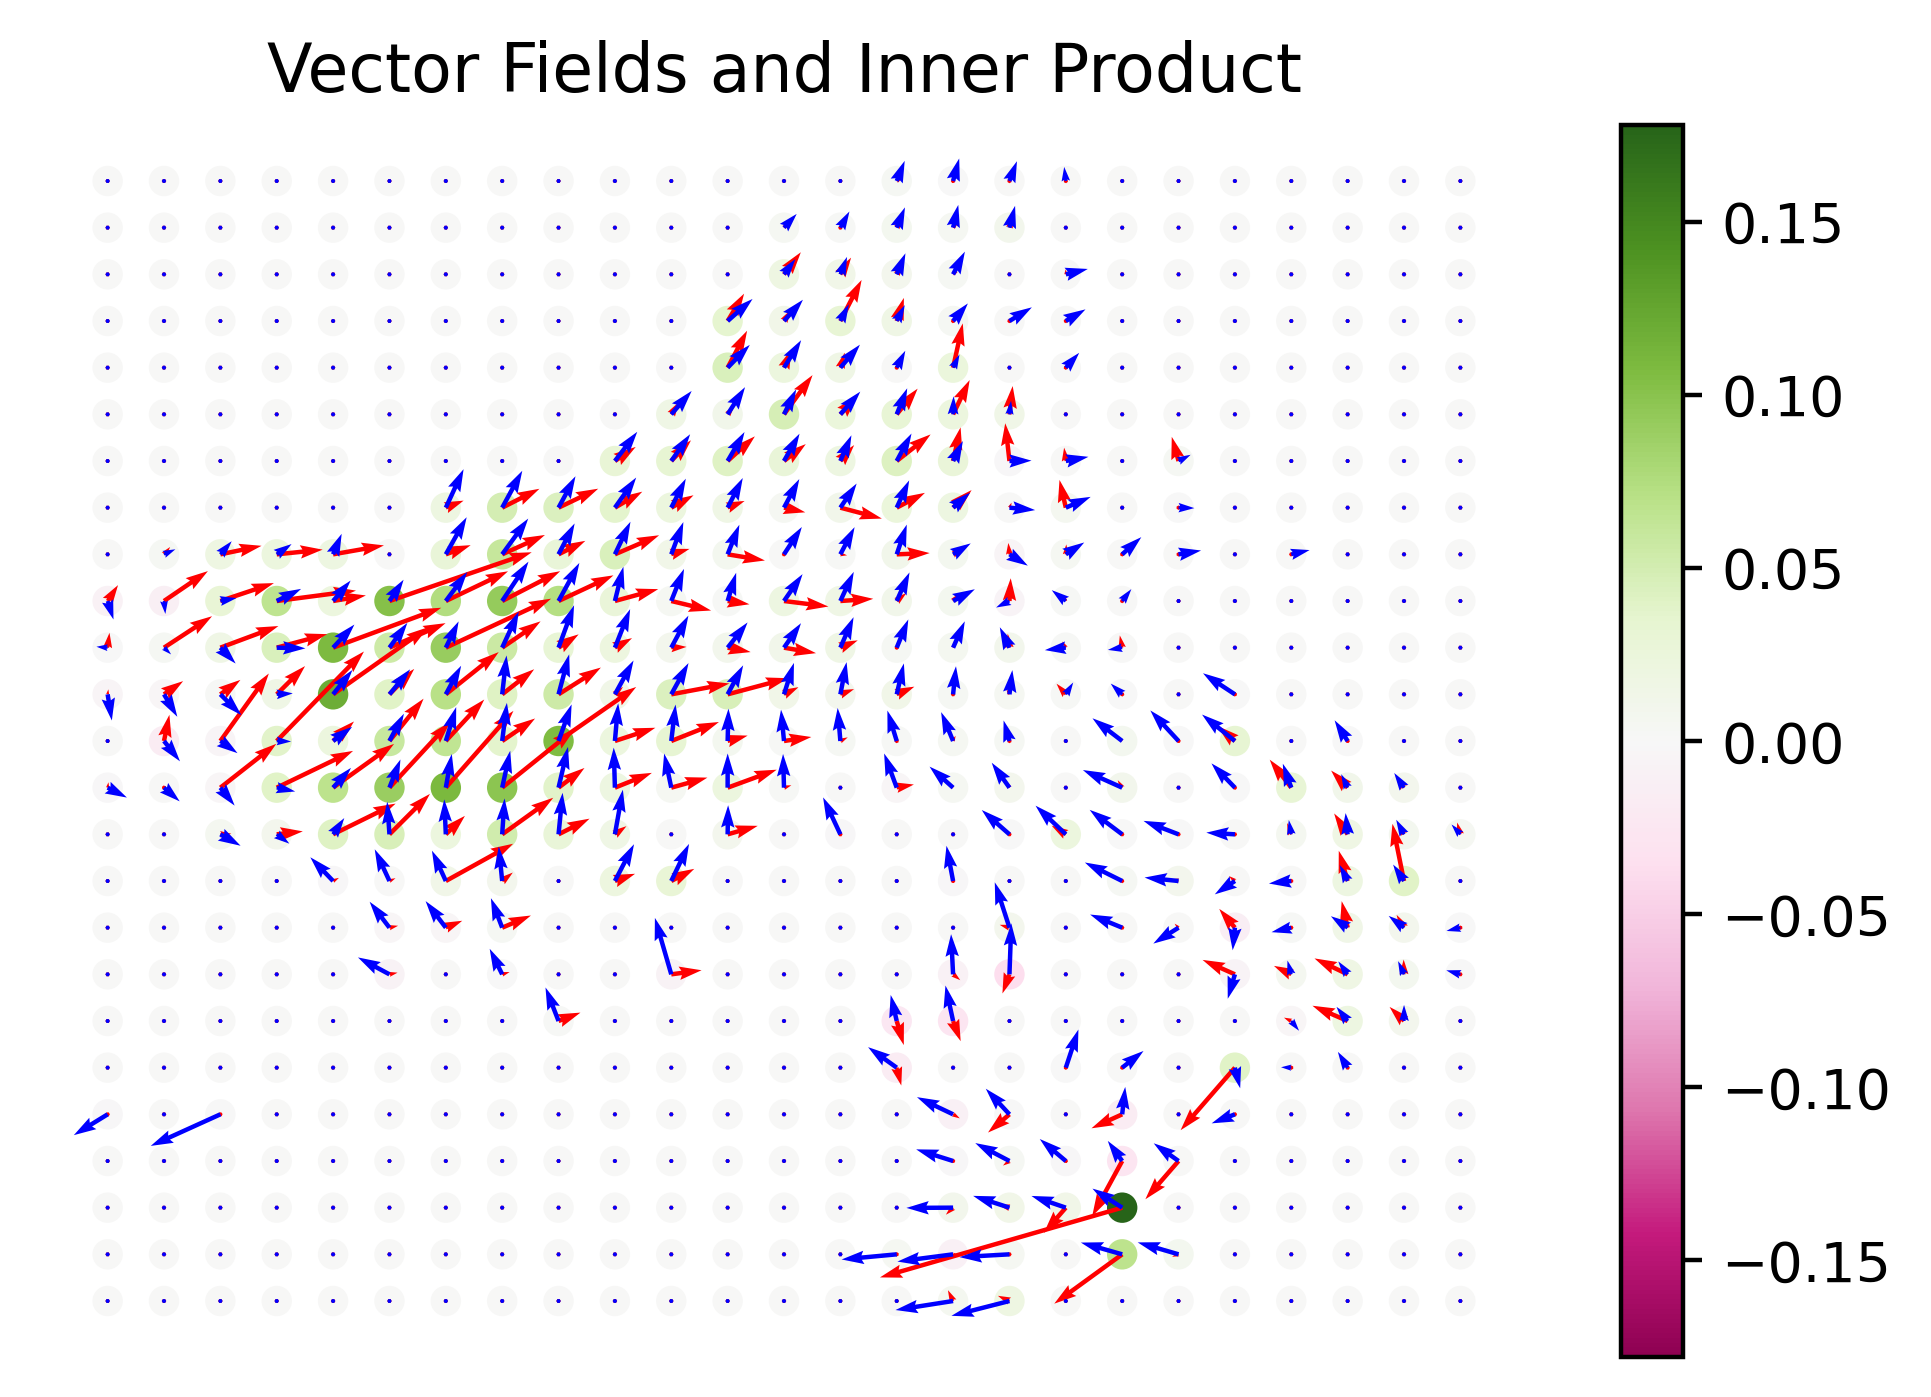

In [350]:
inner_product = np.sum(vector_field * ref_flow, axis=1)
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
vmax = np.abs(inner_product).max()
scatter = ax.scatter(grid_points[:,0], grid_points[:,1], 
                    c=inner_product, cmap='PiYG', s=20,
                    vmin=-vmax, vmax=vmax)

ax.quiver(grid_points[:,0], grid_points[:,1],
          vector_field[:,0], vector_field[:,1],
          angles='xy', scale_units='xy', scale=1,
          alpha=1, color='red', width=0.003)

ax.quiver(grid_points[:,0], grid_points[:,1],
          ref_flow[:, 0], ref_flow[:, 1], 
          angles='xy', scale_units='xy', scale=1,
          alpha=1, color='blue', width=0.003)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_title('Vector Fields and Inner Product')
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
plt.colorbar(scatter)

plt.show()